### Load all dependancies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tkinter import*
from tqdm import tqdm

### Here are all the functions

In [3]:
#Function which opens a GUI window to select file
def gui_fname():
    %gui tk
    # Create Tk root
    root = Tk()
    # Hide the main window
    root.withdraw()
    root.call('wm', 'attributes', '.', '-topmost', True)

    from tkinter import filedialog
    infiles = filedialog.askopenfilename(multiple=False)

    return infiles
   
    
def import_trajectories(file, exposure_time, pixel_size):
    
    trajectories = []

    for i in tqdm(range(len(lines))):
        temp_times = []
        temp_x = []
        temp_y = []
        temp_msd = []

        if '%% Trajectory' in lines[i]:
            line_counter = i+2
            while len(lines[line_counter])>1:
                temp_times.append(float(lines[line_counter].split(' ')[0])*exposure_time)
                temp_x.append(float(lines[line_counter].split(' ')[1])*pixel_size)
                temp_y.append(float(lines[line_counter].split(' ')[2])*pixel_size)
                line_counter+=1
            else:
                #calculate mean square displacement
                dx = np.diff(temp_x)
                dy = np.diff(temp_y)
                
                dx_sq = np.square(dx)
                dy_sq = np.square(dy)

                for i in range(len(dx)):
                    temp_msd.append(dx_sq[i]+dy_sq[i]) 
                cum_msd = np.cumsum(temp_msd)

                trajectories.append([temp_times[1::],temp_x,temp_y,dx,dy,temp_msd,cum_msd])
                pass

    print('In total ', str(len(trajectories)), 'trajectories were found')
    if len(trajectories) ==0:
        print('!!! Check file, no trajectories were found!')
    return trajectories

def filt_traj_len(trajectories, min_trajectory_len):
    traj_filtered = []

    for i in range(len(trajectories)):
        if len(trajectories[i][0])>min_trajectory_len:
            traj_filtered.append(trajectories[i])
        else:
            continue
    print('Total ', str(len(traj_filtered)), ' are left after filtering by lenght')
    return traj_filtered

def traj_start_zero (traj):
    traj_moved = []
    for i in range(len(traj)):
        start_x = traj[i][1][0]
        start_y = traj[i][2][0]
        start_t = traj[i][0][0]
        new_x = [x-start_x for x in traj[i][1]]
        new_y = [y-start_y for y in traj[i][2]]
        new_t = [t-start_t for t in traj[i][0]]
        traj_moved.append([new_t,new_x,new_y,traj[i][3],traj[i][4],traj[i][5], traj[i][6]])
    return traj_moved

### Load file and read all lines

In [4]:
filename = 'Water_Beads.txt'

#IF GUI is used, then uncomment this line
#filename = str(gui_fname())
print(filename)

#read all lines
with open(filename) as f:
    lines = f.readlines()
f.close()

Water_Beads.txt


### Configure pixel size and exsposure time

In [6]:
#Requires manual input of imaging parameters
exposure_time = 50e-3# in seconds
pixel_size = 1e-6/(7.7/2)#in meters while 1um size bead corresponds to 7.7/2 pixels with a 20X objective for 512*512 pixel size
cut_lenght = 50#in frames

### Load trajectories of 1 file into arrays

In [7]:
#import all trajectories
traj_all = import_trajectories(lines, exposure_time, pixel_size)

#filter trajectories by lenght
traj_filt = filt_traj_len(traj_all, 50)

#starting points of trajectrories are moved to zero
traj_moved = traj_start_zero(traj_filt)

100%|█████████████████████████████████████████████████████████████████████| 179865/179865 [00:00<00:00, 1005335.10it/s]


In total  359 trajectories were found
Total  121  are left after filtering by lenght


Text(0.5, 0, 'Distance, um')

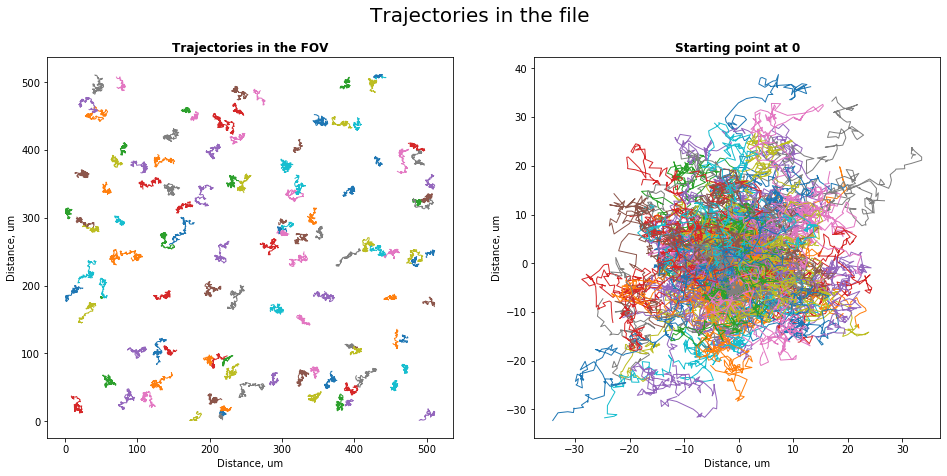

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 7))
fig.suptitle('Trajectories in the file', fontsize = 20)
for i in range(len(traj_filt)):
    ax1.plot(np.divide(traj_filt[i][1],pixel_size) , np.divide(traj_filt[i][2],pixel_size), lw = 1)
ax1.set_title('Trajectories in the FOV', fontweight='bold')

for a in range(len(traj_moved)):
    ax2.plot(np.divide(traj_moved[a][1],pixel_size), np.divide(traj_moved[a][2],pixel_size), lw = 1)
ax2.set_title('Starting point at 0', fontweight='bold')

ax1.set_ylabel('Distance, um')
ax2.set_ylabel('Distance, um')
ax1.set_xlabel('Distance, um')
ax2.set_xlabel('Distance, um')

### Calculate diffusion coeficients

In [9]:
# Theoretical Value of D
d = 0.88e-6 # diameter in meters
eta = 1e-3 # viscosity of water in SI units (Pascal-seconds)
kB = 1.38e-23 # Boltzmann constant
T = 293 # Temperature in degrees Kelvin

#Calculate theoretical D
D_theoretical = kB * T / (3 * np.pi * eta * d);
print('Theoretical value of D in m^2/s = ', D_theoretical)

# Average all MSD values and print average MSD in filtered trajectories
all_MSDs = []
for i in range(len(traj_filt)):
    all_MSDs.append(np.mean(traj_filt[i][5]))
print('Calculated average value of MSD in m^2: ', np.mean(all_MSDs))

#Calculate experimental D
tau = exposure_time
dimensions = 2

D_experimental = np.mean(all_MSDs)/(2*tau*dimensions)
print('Calculated value D in m^2/s: ', D_experimental)

Theoretical value of D in m^2/s =  4.875205279528558e-13
Calculated average value of MSD in m^2:  1.156558140321707e-13
Calculated value D in m^2/s:  5.782790701608535e-13


## Plot MSDs

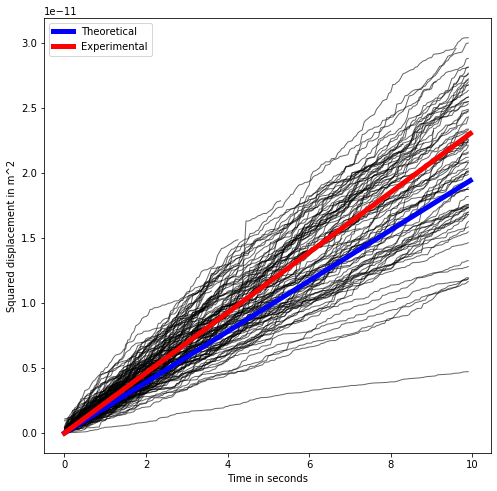

In [10]:
#here cummulative MSDs are plotted together with experimental and theoretical MSD

#Find the longest trajectory for interpolation
max_len = np.max([len(elem[0]) for elem in traj_moved])

#Make interpolated time trace
time = np.linspace(0,max_len, max_len)*tau

#Calculate interpolated MSD values according to a diffusion formula

theoretical_curve = np.linspace(0,max_len, max_len)*D_theoretical*dimensions * tau *2
experimental_curve = np.linspace(0,max_len, max_len)*D_experimental*dimensions * tau*2

#Plot the results
fig = plt.figure(figsize=(8, 8))

for i in range(len(traj_moved)):
    plt.plot(traj_moved[i][0], traj_moved[i][6], lw = 1, color = 'black', alpha=0.6)

D_th, = plt.plot(time, theoretical_curve, lw = 5, color = 'blue', alpha=1, label="Theoretical")
D_exp, = plt.plot(time, experimental_curve, lw = 5, color = 'red', alpha=1, label="Experimental")

# Create a legend for the first line.
plt.legend(handles=[D_th,D_exp], loc='upper left')

plt.ylabel('Squared displacement in m^2')
plt.xlabel('Time in seconds')
plt.show()

## Velocities of particles

Velocities of particles are basically absolute dx and dy values divided by exposure time. Here I will average the whole trajectory for each particle to get the mean velocity value. If velocities in x and y directions are the same, means that most likely beads are moving randomly.

In [11]:
x_velocities = []
y_velocities = []

for i in range(len(traj_moved)):
    x_velocities.append(np.mean(abs(traj_moved[i][3]))/exposure_time)
    y_velocities.append(np.mean(abs(traj_moved[i][4]))/exposure_time)
    
print('Mean speed in x axis in m/s', np.mean(x_velocities), 'STDEV in m/s: ', np.std(x_velocities))
print('Mean speed in y axis in m/s', np.mean(y_velocities), 'STDEV in m/s: ', np.std(y_velocities))

Mean speed in x axis in m/s 3.790158139846514e-06 STDEV in m/s:  5.172070556413048e-07
Mean speed in y axis in m/s 3.746673234153819e-06 STDEV in m/s:  6.083951107781459e-07


Text(0.5, 0, 'Speed in m/s')

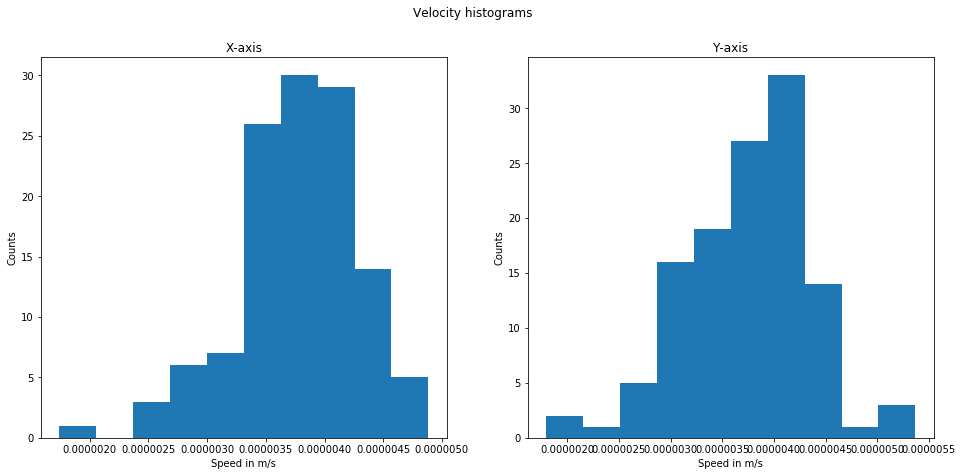

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 7))
fig.suptitle('Velocity histograms')
ax1.hist(x_velocities)
ax1.set_title('X-axis')
ax2.hist(y_velocities)
ax2.set_title('Y-axis')

ax1.set_ylabel('Counts')
ax2.set_ylabel('Counts')
ax1.set_xlabel('Speed in m/s')
ax2.set_xlabel('Speed in m/s')

## Auto and Cross correlations

By  construction,  the  particle  displacements  are  independent.  The  change  in  position  at  one  time  should exhibit no relationship at all to the change at any other time. This can be verified with correlations of the signals.

In autocorrelation case the middle value always stands out because x correlates perfectly with itself when there is no offset (at 0 lag).

In cross correlation case, correlation function returns a cross correlation matrix. The cross correlation can be used to test  the  relationship  (or  lack  thereof)  between  one  particle's  trajectory  and  another's.  If  two  particles  move independently,  the  cross  correlations  should  be  very  small.  

The code below computes auto and cross correlations between dx and dy (displacement of particles over time) for all particles in x and y axes.

In [13]:
from itertools import combinations

def rSubset(arr, r): 
    # return list of all subsets of length r 
    # to deal with duplicate subsets use  
    # set(list(combinations(arr, r))) 
    return list(combinations(arr, r))
def auto_corr(array1, array2):
    xcorr = np.correlate(array1, array2, mode='full')
    return xcorr

In [14]:
#autocorrelations (correlating signal with itself for all signals)
x_auto_corr_array = []
y_auto_corr_array = []
for i in range(len(traj_moved)): 
    x_auto_corr_array.append(auto_corr(traj_moved[i][3][0:cut_lenght], traj_moved[i][3][0:cut_lenght]))
    y_auto_corr_array.append(auto_corr(traj_moved[i][4][0:cut_lenght], traj_moved[i][4][0:cut_lenght]))
x_axis = np.linspace(-cut_lenght+1, cut_lenght-1, cut_lenght*2-1)

100%|███████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 359.23it/s]


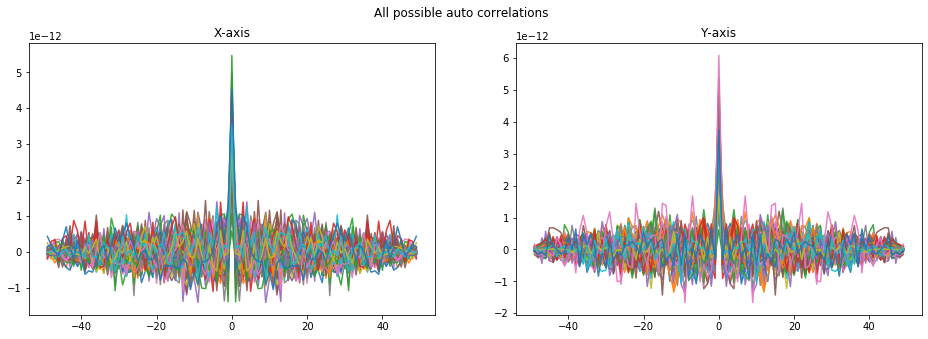

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 5))
fig.suptitle('All possible auto correlations')
for i in tqdm(range(len(x_auto_corr_array))):
    ax1.plot(x_axis, x_auto_corr_array[i], alpha = 0.9)
    ax1.set_title('X-axis')
    ax2.plot(x_axis, y_auto_corr_array[i], alpha = 0.9)
    ax2.set_title('Y-axis')

## Cross correlations
Here all the posible combinations of 2 signals are cross-correlated. It is done for x and then for y axes. This runs slowly, because of the amount of computation needed.

In [16]:
dx_array = []
dy_array = []
for i in range(len(traj_moved)):
    dx_array.append(traj_moved[i][3][0:cut_lenght])
    dy_array.append(traj_moved[i][4][0:cut_lenght])
    
all_dx_combinations = rSubset(dx_array,2)
all_dy_combinations = rSubset(dy_array,2)

x_corr_array = []
y_corr_array = []
for a in range(len(all_dx_combinations)): 
    x_corr_array.append(auto_corr(all_dx_combinations[a][0], all_dx_combinations[a][1]))
    y_corr_array.append(auto_corr(all_dy_combinations[a][0], all_dy_combinations[a][1]))
    
x_axis = np.linspace(-cut_lenght+1, cut_lenght-1, cut_lenght*2-1)

100%|██████████████████████████████████████████████████████████████████████████████| 7260/7260 [01:12<00:00, 55.46it/s]


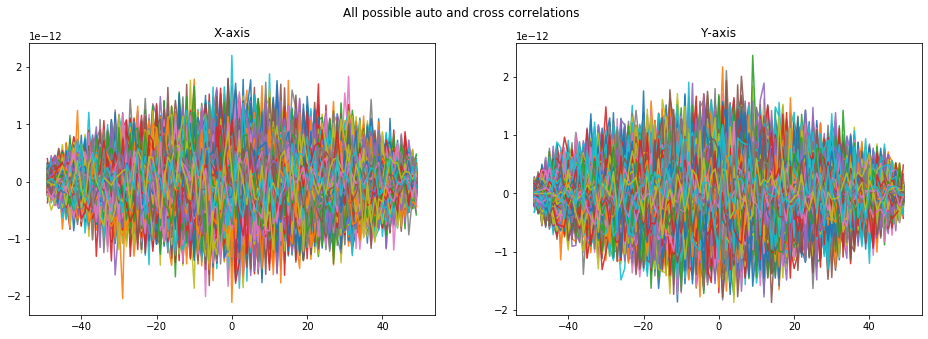

In [17]:
#HERE there are a lot of curves to plot, so the code is obviuosly slow

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 5))
fig.suptitle('All possible auto and cross correlations')
for i in tqdm(range(len(x_corr_array))):
    ax1.plot(x_axis, x_corr_array[i], alpha = 0.9)
    ax1.set_title('X-axis')
    ax2.plot(x_axis, y_corr_array[i], alpha = 0.9)
    ax2.set_title('Y-axis')